In [1]:
import json
import numpy as np
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal
import torch
import time


class MyDynamicDatasetLoader(object):
    def __init__(self):
        self._read_web_data()

    def _read_web_data(self):
        with open('../data/graphs/grafo_corr_sliding0.2.json') as f:
            self._dataset = json.load(f)

    def _get_edges(self):
        self._edges = []
        for time in self._dataset["time_periods"]:
            self._edges.append(
                np.array(self._dataset["edge_mapping"]["edge_index"][str(time)]).T
            )
        self._edges = self._edges[self.lags-1:]

    def _get_node_ids(self):
        self._node_ids = np.array(self._dataset["node_ids"])
    
    def _get_edge_weights(self):
        self._edge_weights = []
        for time in self._dataset["time_periods"]:
            self._edge_weights.append(
                np.array(self._dataset["edge_mapping"]["edge_weight"][str(time)])
            )
        self._edge_weights = self._edge_weights[self.lags-1:]

    def _get_targets_and_features(self):
        stacked_target = np.array(self._dataset["y"])
        self.scale = []
        for i in range(24):
            self.scale.append(max(stacked_target[:,i]))
        self.scale = np.array(self.scale)
        self.mu = np.mean(stacked_target, axis=0)
        self.sigma = np.std(stacked_target, axis=0)
        standardized_target = (stacked_target - self.mu) / (self.sigma + 10 ** -10)
        #standardized_target = stacked_target/self.scale
        self.features = [
            standardized_target[i : i + self.lags, :].T
            for i in range(len(self._dataset["time_periods"])-self.lags+1)
        ]
        self.targets = [
            standardized_target[i + self.lags, :].T
            for i in range(len(self._dataset["time_periods"])-self.lags+1)
        ]

    def get_dataset(self, lags: int = 4) -> DynamicGraphTemporalSignal:
        """Returning the Wind Speed data iterator.

        Args types:
            * **lags** *(int)* - The number of time lags.
        Return types:
            * **dataset** *(StaticGraphTemporalSignal)* - The Wind Speed dataset.
        """
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_node_ids()
        self._get_targets_and_features()
        dataset = DynamicGraphTemporalSignal(
            self._edges, self._edge_weights, self.features, self.targets
        )
        print(self._dataset["time_periods"][0])
        return dataset


In [2]:
lags = 3
out_channels = 10
loader = MyDynamicDatasetLoader()
dataset = loader.get_dataset(lags=lags)
dataset[2]

03/31/2000


Data(x=[24, 3], edge_index=[2, 548], edge_attr=[548], y=[24])

In [3]:
#descale(dataset[0].y.detach().cpu().numpy(), sigma, mu, scale)#[:,0]

In [3]:
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch_geometric_temporal.nn.recurrent import GConvGRU, TGCN, GConvLSTM
from torch_geometric_temporal.signal import temporal_signal_split

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

In [9]:
# train_dataset[0].edge_attr

In [4]:
import sys
import os
sys.path.append(os.path.abspath('..'))
#from updated_models.GConvGRU_w import GConvGRU_W
from updated_models.RecGRU import RecGRU_W
from updated_models.RecGNN import RecG
from updated_models.RecGNN_up import RecG_up

In [5]:
#descale(train_dataset[6349].y.detach().cpu().numpy(), sigma, mu, scale)#[:,2]

In [5]:
#descale(test_dataset[1587].y.detach().cpu().numpy(), sigma, mu, scale)#[:,2]

In [25]:
class GNN(torch.nn.Module):
    def __init__(self, node_features):
        super(GNN, self).__init__()
        self.recurrent = RecG_up(in_channels=node_features, num_stacks=1, toll=1, act='tanh')
        self.linear = torch.nn.Linear(node_features, 1)#out_channels

    def forward(self, x, edge_index, edge_weight, H):
        H = self.recurrent(x, edge_index, edge_weight, H)
        h = H
        #h = F.relu(h)
        h = self.linear(h)
        return h,H

In [26]:
model = GNN(node_features = lags)
name_model = model.recurrent.__class__.__name__.split('_')[0]
name_model = 'RecGNN'

In [27]:
sigma = loader.sigma
mu = loader.mu
scale = loader.scale
def descale(output, sigma, mu, scale):
    return output*sigma + mu#scale

  Epoch 1/200
Training loss:  1.2101376
  Epoch 2/200
Training loss:  1.1899045
  Epoch 3/200
Training loss:  1.1705232
  Epoch 4/200
Training loss:  1.1517082
  Epoch 5/200
Training loss:  1.1333492
  Epoch 6/200
Training loss:  1.115307
  Epoch 7/200
Training loss:  1.0977422
  Epoch 8/200
Training loss:  1.0806744
  Epoch 9/200
Training loss:  1.0642806
  Epoch 10/200
Training loss:  1.0489305
  Epoch 11/200
Training loss:  1.0350093
  Epoch 12/200
Training loss:  1.0229808
  Epoch 13/200
Training loss:  1.0134012
  Epoch 14/200
Training loss:  1.0073591
  Epoch 15/200
Training loss:  1.0054138
  Epoch 16/200
Training loss:  1.0065274
  Epoch 17/200
Training loss:  1.0097097
  Epoch 18/200
Training loss:  1.0134319
  Epoch 19/200
Training loss:  1.0162433
  Epoch 20/200
Training loss:  1.0174091
  Epoch 21/200
Training loss:  1.01688
  Epoch 22/200
Training loss:  1.0151167
  Epoch 23/200
Training loss:  1.0127243
  Epoch 24/200
Training loss:  1.0103376
  Epoch 25/200
Training loss

Text(0.5, 0, 'epoch')

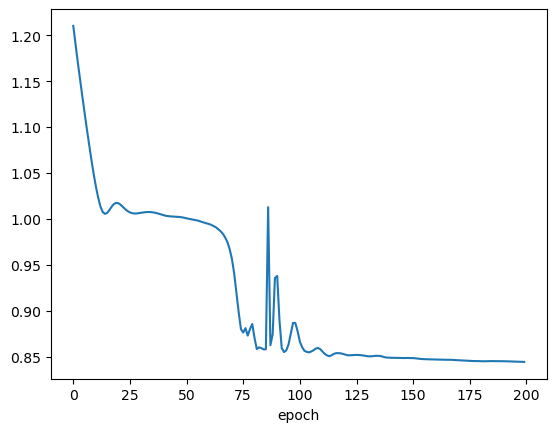

In [28]:
#model = model.to('cuda')
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = F.mse_loss

start_time = time.perf_counter() # Start timer
num_epochs = 200
losses = []
outputs = []  #
targets = []  #
weights = []
for epoch in range(num_epochs):
    loss = 0
    epoch_outputs = []  #
    epoch_targets = []  #
    H = torch.zeros(24,out_channels)
    #C = torch.zeros(24,out_channels)
    print("  Epoch %d/%d" % (epoch+1,num_epochs))
    for time_step, snapshot in enumerate(train_dataset):
        #snapshot.to('cuda')
        output, H = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, H=H)
        loss = loss + loss_fn(output.T[0], snapshot.y)
        epoch_outputs.append(descale(output.T[0].detach().cpu().numpy(), sigma, mu, scale))  #
        epoch_targets.append(descale(snapshot.y.detach().cpu().numpy(), sigma, mu, scale))   #
        # if torch.isnan(output).any():
        #     print(time_step)
    
    loss = loss/(time_step+1)
    weights.append(torch.norm(model.recurrent.weight))
    if torch.norm(model.recurrent.weight).detach().numpy() > 1:
        print('Warning')
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    losses.append(loss.cpu().detach().numpy())
    outputs.append(epoch_outputs)  #
    targets.append(epoch_targets)  #
    print('Training loss: ', losses[-1])

end_time = time.perf_counter() # End timer
print("Elapsed time: ", end_time - start_time) # Calculate elapsed time

plt.plot(losses)
plt.xlabel("epoch")

In [46]:
# for time_step, snapshot in enumerate(train_dataset):
#     time_step
# time_step

In [26]:
epoch

199

In [9]:
# losses

In [12]:
model.__repr__()

'GNN(\n  (recurrent): RecG(3, 5, num_stacks=1, act=Tanh())\n  (linear): Linear(in_features=5, out_features=1, bias=True)\n)'

In [42]:
model.recurrent.weight

Parameter containing:
tensor([[[[-4.8133]]]], requires_grad=True)

In [26]:
sum_t = 0
j = 4
for t in model.recurrent.list_t[6349*j:6349*(j+1)]:
    sum_t = t + sum_t
    if t > 30:
        print(t)
    if t < 3:
        print(t)
sum_t/6350

10.329763779527559

In [29]:
sum_list = []
num_epochs = 200
for j in range(num_epochs):
    sum_t = 0
    for t in model.recurrent.list_t[6349*j:6349*(j+1)]:
        sum_t = t + sum_t
        if t > 501:
            print(str(t)+' - '+str(j+1))
        if t < 2:
            print(str(t)+' - '+str(j+1))
    sum_list.append(sum_t/6350)
sum_list

[3.0563779527559056,
 3.0274015748031498,
 3.0337007874015747,
 3.0738582677165356,
 3.1277165354330707,
 3.2044094488188977,
 3.380472440944882,
 3.5513385826771655,
 3.674803149606299,
 3.779685039370079,
 3.868661417322835,
 3.956220472440945,
 4.05007874015748,
 4.256220472440945,
 4.542834645669291,
 4.695590551181103,
 4.7743307086614175,
 4.809763779527559,
 4.815748031496063,
 4.805196850393701,
 4.790393700787401,
 4.773543307086614,
 4.756692913385827,
 4.733228346456693,
 4.722834645669291,
 4.712125984251968,
 4.705984251968504,
 4.699842519685039,
 4.696062992125984,
 4.696850393700787,
 4.7028346456692915,
 4.7064566929133855,
 4.714330708661417,
 4.724566929133858,
 4.7343307086614175,
 4.74755905511811,
 4.7622047244094485,
 4.776535433070866,
 4.794173228346457,
 4.811968503937008,
 4.846929133858268,
 4.915433070866142,
 5.0007874015748035,
 5.084409448818898,
 5.171811023622047,
 5.253543307086614,
 5.323307086614173,
 5.3877165354330705,
 5.438425196850393,
 5.48960

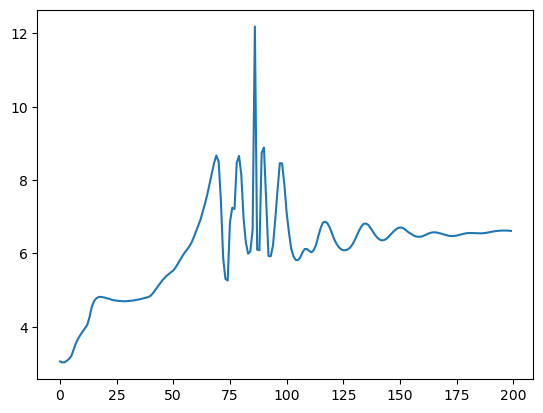

In [30]:
plt.plot(sum_list)

In [12]:
# weights

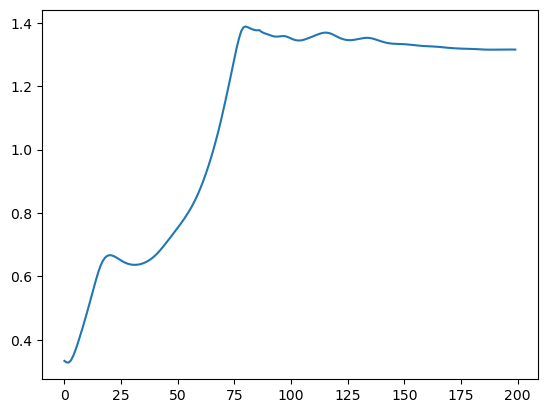

In [31]:
weights_list = []
# num_epochs = 100
for j in range(num_epochs):
    weights_list.append(weights[j].detach().numpy())
plt.plot(weights_list)

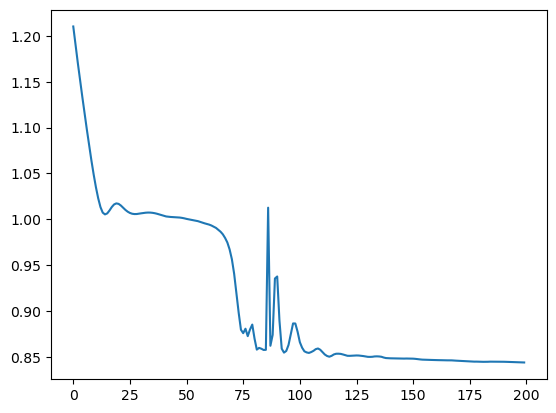

In [32]:
plt.plot(losses)

In [33]:
for name, p in model.named_parameters():
    print(name)
    print(p.numel())
print('-------')
tot = sum(p.numel() for p in model.parameters())
print('total parameters = '+str(tot))

recurrent.weight
9
recurrent.bias
72
linear.weight
3
linear.bias
1
-------
total parameters = 85


In [ ]:
# a=model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
# print(a)

In [ ]:
# print(epoch_outputs.append(descale(output.T[0].detach().cpu().numpy(), sigma, mu, scale)))
# print(epoch_targets.append(descale(snapshot.y.detach().cpu().numpy(), sigma, mu, scale)))

In [34]:
outputs_hourly = []
targets_hourly = []
for j in range(24):
    outhourlist = [outputs[-1][i][j] for i in range(len(outputs[-1]))]
    tarhourlist = [targets[-1][i][j] for i in range(len(outputs[-1]))]
    outputs_hourly.append(outhourlist)
    targets_hourly.append(tarhourlist)

In [35]:
#Test set
test_outputs = []  #
test_targets = []  #
for time_step, snapshot in enumerate(test_dataset):
    #snapshot.to('cuda')
    output, H = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, H)
    test_output = descale(output.T[0].detach().cpu().numpy(), sigma, mu, scale)
    test_snapshot = descale(snapshot.y.detach().cpu().numpy(), sigma, mu, scale)
    test_outputs.append(test_output)  #
    test_targets.append(test_snapshot)   #
#snapshot.x


In [36]:
outputs_hourly_test = []
targets_hourly_test = []
for j in range(24):
    outhourlist = [test_outputs[i][j] for i in range(len(test_outputs))]
    tarhourlist = [test_targets[i][j] for i in range(len(test_outputs))]
    outputs_hourly_test.append(outhourlist)
    targets_hourly_test.append(tarhourlist)

In [37]:
mse_test = []
for j in range(24):
    sqdiff = [(a - b)**2 for a, b in zip(targets_hourly_test[j], outputs_hourly_test[j])]
    mse_test.append(np.mean(sqdiff))
mse_test

[1026.2917938676767,
 541.9335578489711,
 304.20698606957035,
 518.396359829314,
 635.168307978936,
 1295.7379089912467,
 4165.606385208546,
 6229.1588054708245,
 7266.033720255932,
 9436.014506434758,
 12646.687800475793,
 14308.23798969964,
 12539.480061496428,
 15947.20904835884,
 16500.253551705435,
 17513.978146649933,
 23557.878732275545,
 27167.168554733154,
 18794.291424847983,
 13297.240249702203,
 8260.417309439003,
 4374.194742380414,
 2077.538295626938,
 1757.0570142929835]

In [38]:
np.mean(mse_test)

9173.340885568337

In [39]:
mae_train = []
for j in range(24):
    absdiff = [abs(a - b) for a, b in zip(targets_hourly[j], outputs_hourly[j])]
    mae_train.append(np.mean(absdiff))
mae_train

[14.018020325641286,
 13.755721591061997,
 11.901466724160622,
 11.146750552641633,
 11.219919113135074,
 12.598147484518043,
 24.965135712687612,
 29.40289765537765,
 35.66582520891784,
 40.15271741064375,
 52.46231989107038,
 63.72594101133852,
 62.400498516748804,
 66.47389147047649,
 68.01456159715163,
 68.92276322655886,
 81.04280907385507,
 96.3385027355799,
 64.33682760578004,
 54.27834765421573,
 46.43665446691962,
 43.95242762785336,
 21.904038561952483,
 22.578515834143435]

In [40]:
np.mean(mae_train)

42.403945877184576

In [41]:
mse_train = []
for j in range(24):
    sqdiff = [(a - b)**2 for a, b in zip(targets_hourly[j], outputs_hourly[j])]
    mse_train.append(np.mean(sqdiff))
mse_train

[903.2078277045474,
 756.0176527191891,
 461.6761766872068,
 381.64036026601644,
 448.4955210703894,
 609.1727457032474,
 3608.2845922396655,
 4689.861291412765,
 6311.121830858991,
 8410.44594884304,
 12278.099191859537,
 16486.344421901074,
 16943.129359929204,
 18677.6809489137,
 19707.252133350317,
 19960.191560173975,
 22744.90991432279,
 28794.308529404356,
 17483.09464521474,
 12802.546781807929,
 9765.690045402924,
 8243.061309428947,
 2333.301224564714,
 2000.9172898174195]

In [42]:
np.mean(mse_train)

9783.352137649861

In [43]:
mae_test = []
for j in range(24):
    absdiff = [abs(a - b) for a, b in zip(targets_hourly_test[j], outputs_hourly_test[j])]
    mae_test.append(np.mean(absdiff))
mae_test

[10.251198418641598,
 8.913493963327404,
 9.054013416566077,
 10.107541176016452,
 10.656839738381182,
 12.063997221853095,
 22.649712906973047,
 28.060627125277456,
 33.40501861301251,
 41.847651386215595,
 55.92368938575968,
 66.1456511463456,
 61.27941068193586,
 70.22048401293696,
 68.1056164225161,
 69.77747323823235,
 87.20474199609183,
 100.05124593181424,
 69.67533514124537,
 55.869906164402714,
 44.441714927953285,
 36.053979480117654,
 16.638986783589974,
 15.426803396870445]

In [44]:
np.mean(mae_test)

41.82604719483652

In [20]:
mse_train_gconv = mse_train
mse_test_gconv = mse_test
mae_train_gconv = mae_train
mae_test_gconv = mae_test

In [46]:
mse_train_gconv = [round(v, 1) for v in mse_train_gconv]
mse_test_gconv = [round(v, 1) for v in mse_test_gconv]

In [25]:
mae_train_gconv = [round(v, 1) for v in mae_train_gconv]
mae_test_gconv = [round(v, 1) for v in mae_test_gconv]

In [26]:
import pandas as pd
df_mse = pd.DataFrame({'a': mse_train_gconv, 'b': mse_test_gconv, 'c': mae_train_gconv, 'd': mae_test_gconv})

# Esportare la tabella in formato LaTeX
latex_table = df_mse.to_latex(index=False)
print(latex_table)

\begin{tabular}{rrrr}
\toprule
      a &       b &    c &    d \\
\midrule
  798.8 &   825.1 & 11.7 &  9.1 \\
  642.3 &   436.8 & 11.1 &  7.9 \\
  353.4 &   229.0 &  9.5 &  6.9 \\
  274.2 &   368.8 &  8.8 &  7.0 \\
  325.4 &   488.5 &  8.8 &  7.5 \\
  491.7 &  1157.5 & 10.4 &  9.5 \\
 3215.1 &  3669.5 & 22.6 & 19.9 \\
 3742.7 &  5318.3 & 25.3 & 24.5 \\
 5245.3 &  6224.9 & 30.9 & 27.2 \\
 7167.8 &  8446.9 & 35.3 & 34.0 \\
10166.5 & 11866.6 & 44.8 & 45.3 \\
13143.2 & 13076.9 & 52.4 & 50.4 \\
13367.6 & 11473.1 & 50.9 & 46.4 \\
14717.1 & 14885.0 & 54.2 & 53.3 \\
15182.5 & 14571.6 & 54.2 & 51.5 \\
15254.2 & 15721.8 & 54.9 & 55.1 \\
18438.6 & 21267.2 & 66.3 & 69.2 \\
22688.6 & 24400.5 & 75.2 & 77.6 \\
14220.4 & 16390.5 & 53.0 & 55.5 \\
10776.8 & 12377.8 & 45.4 & 46.0 \\
 8159.4 &  8058.3 & 39.1 & 35.7 \\
 6999.4 &  4244.2 & 37.0 & 25.0 \\
 1809.6 &  2117.0 & 17.9 & 14.4 \\
 1828.8 &  1634.4 & 19.4 & 13.5 \\
\bottomrule
\end{tabular}



In [27]:
df_mse.to_csv('../errors/errori_GConv.csv', index=False)

In [35]:
#unisco train e test
outputs_merged = [l1 + l2 for l1, l2 in zip(outputs_hourly, outputs_hourly_test)]
targets_merged = [l1 + l2 for l1, l2 in zip(targets_hourly, targets_hourly_test)]

In [36]:
list_ids = loader._node_ids
dict = list_ids.item()
inverse_dict = {value: key for key, value in dict.items()}
inverse_dict.get(0)

'00:00'

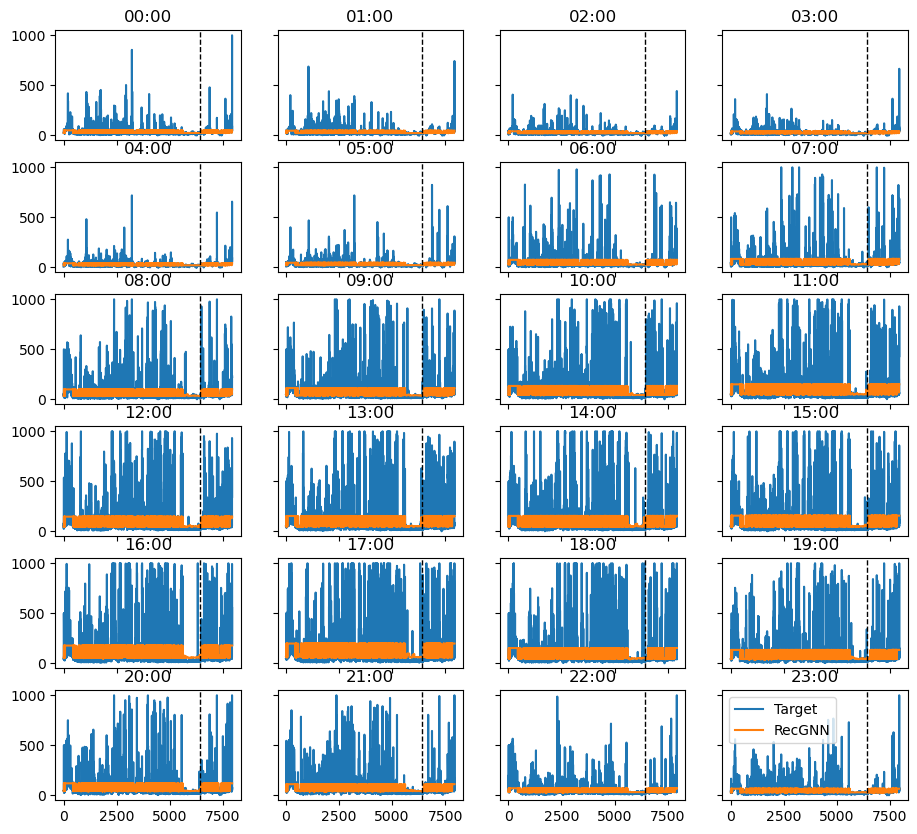

In [37]:
fig, axs = plt.subplots(6, 4, figsize=(11, 10), sharey=True, sharex=True)

# Iteriamo sulla lista delle matrici e le visualizziamo in subplots
for i in range(6):
    axs[i,0].plot(targets_merged[i*4], label="Target")
    axs[i,0].plot(outputs_merged[i*4], label=name_model)
    axs[i,0].axvline(x=6420, color='black', linestyle='--', linewidth=1)
    axs[i,1].plot(targets_merged[i*4+1], label="Target")
    axs[i,1].plot(outputs_merged[i*4+1], label=name_model)
    axs[i,1].axvline(x=6420, color='black', linestyle='--', linewidth=1)
    axs[i,2].plot(targets_merged[i*4+2], label="Target")
    axs[i,2].plot(outputs_merged[i*4+2], label=name_model)
    axs[i,2].axvline(x=6420, color='black', linestyle='--', linewidth=1)
    axs[i,3].plot(targets_merged[i*4+3], label="Target")
    axs[i,3].plot(outputs_merged[i*4+3], label=name_model)
    axs[i,3].axvline(x=6420, color='black', linestyle='--', linewidth=1)
    axs[i,0].set_title(inverse_dict[i*4])  # Titolo del subplot
    axs[i,1].set_title(inverse_dict[i*4+1])
    axs[i,2].set_title(inverse_dict[i*4+2])
    axs[i,3].set_title(inverse_dict[i*4+3])
    #axs[i].axis('off')  # Nasconde gli assi

plt.legend()
#plt.savefig('../plot/dyn'+name_model.lower()+'.jpg', format='jpg')
# Mostriamo la figura con tutti i subplot
plt.show()

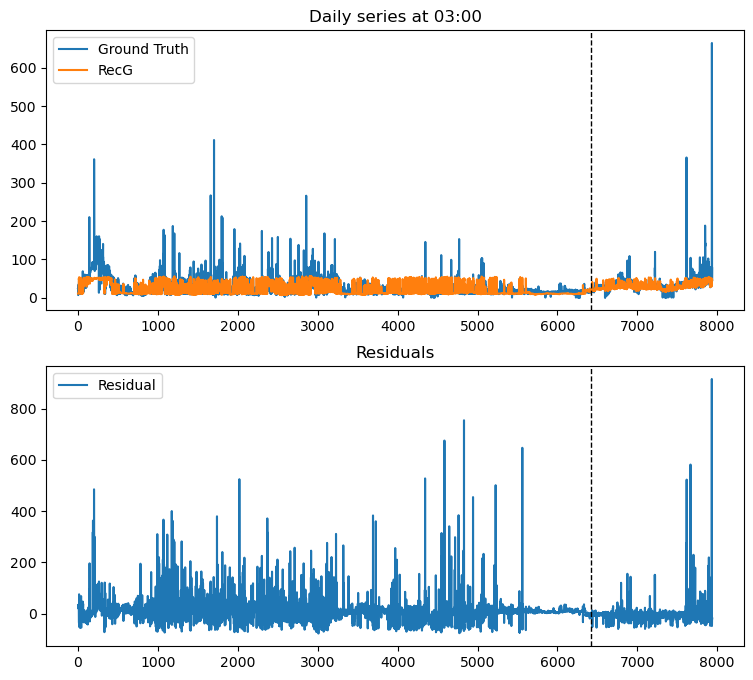

In [32]:
hour = 3

diff = [a - b for a, b in zip(targets_merged[j], outputs_merged[j])]
fig, axs = plt.subplots(2, 1, figsize=(9, 8))
axs[0].plot(targets_merged[hour], label="Ground Truth")
axs[0].plot(outputs_merged[hour], label=name_model)
axs[0].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[0].legend()
axs[0].set_title("Daily series at "+inverse_dict[hour])
axs[1].plot(diff, label="Residual")
axs[1].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[1].legend()
axs[1].set_title("Residuals")
plt.show()

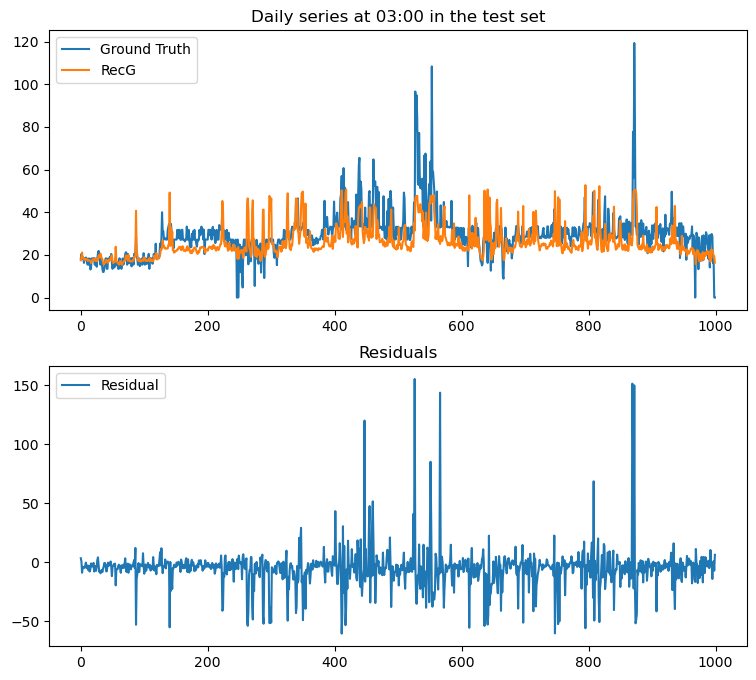

In [33]:
hour = 3

diff = [a - b for a, b in zip(targets_hourly_test[j], outputs_hourly_test[j])]
fig, axs = plt.subplots(2, 1, figsize=(9, 8))
axs[0].plot(targets_hourly_test[hour][:1000], label="Ground Truth")
axs[0].plot(outputs_hourly_test[hour][:1000], label=name_model)
axs[0].legend()
axs[0].set_title("Daily series at "+inverse_dict[hour]+" in the test set")
axs[1].plot(diff[:1000], label="Residual")
axs[1].legend()
axs[1].set_title("Residuals")
plt.show()

In [ ]:
hour1 = 4
hour2 = 16

diff1 = [a - b for a, b in zip(targets_merged[hour1], outputs_merged[hour1])]
diff2 = [a - b for a, b in zip(targets_merged[hour2], outputs_merged[hour2])]
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0,0].plot(targets_merged[hour1], label="Ground Truth")
axs[0,0].plot(outputs_merged[hour1], label=name_model)
axs[0,0].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[0,0].legend()
axs[0,0].set_ylim(-40,1040)
axs[0,0].set_title("Daily series at "+inverse_dict[hour1])
axs[1,0].plot(diff1, label="Residual")
axs[1,0].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[1,0].legend()
axs[1,0].set_ylim(-1040,1040)
axs[1,0].set_title("Residuals")
axs[0,1].plot(targets_merged[hour2], label="Ground Truth")
axs[0,1].plot(outputs_merged[hour2], label=name_model)
axs[0,1].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[0,1].legend()
axs[0,1].set_ylim(-40,1040)
axs[0,1].set_title("Daily series at "+inverse_dict[hour2])
axs[1,1].plot(diff2, label="Residual")
axs[1,1].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[1,1].legend()
axs[1,1].set_ylim(-1040,1040)
axs[1,1].set_title("Residuals")
plt.savefig('plot/focusdyn'+name_model.lower()+'.jpg', format='jpg')
plt.show()

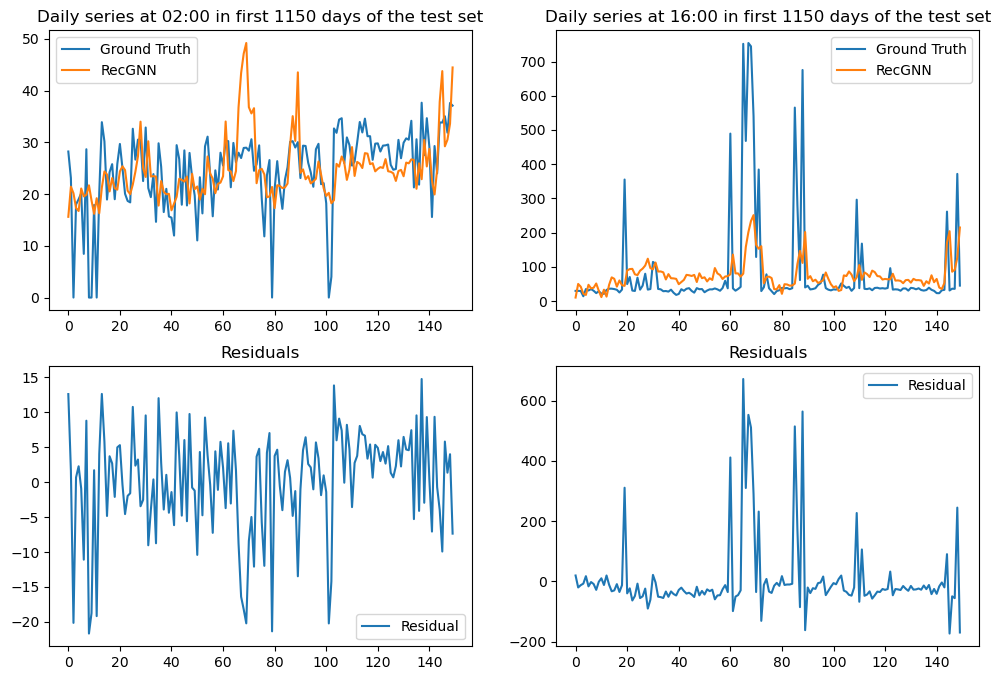

In [37]:
hour1 = 2
hour2 = 16
id=1000
fd=1150

diff1 = [a - b for a, b in zip(targets_hourly_test[hour1], outputs_hourly_test[hour1])]
diff2 = [a - b for a, b in zip(targets_hourly_test[hour2], outputs_hourly_test[hour2])]
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0,0].plot(targets_hourly_test[hour1][id:fd], label="Ground Truth")
axs[0,0].plot(outputs_hourly_test[hour1][id:fd], label=name_model)
axs[0,0].legend()
#axs[0,0].set_ylim(-40,1040)
axs[0,0].set_title("Daily series at "+inverse_dict[hour1]+" in first "+str(fd-id)+" days of the test set")
axs[1,0].plot(diff1[id:fd], label="Residual")
axs[1,0].legend()
#axs[1,0].set_ylim(-1040,1040)
axs[1,0].set_title("Residuals")
axs[0,1].plot(targets_hourly_test[hour2][id:fd], label="Ground Truth")
axs[0,1].plot(outputs_hourly_test[hour2][id:fd], label=name_model)
axs[0,1].legend()
#axs[0,1].set_ylim(-40,1040)
axs[0,1].set_title("Daily series at "+inverse_dict[hour2]+" in first "+str(fd-id)+" days of the test set")
axs[1,1].plot(diff2[id:fd], label="Residual")
axs[1,1].legend()
#axs[1,1].set_ylim(-1040,1040)
axs[1,1].set_title("Residuals")
plt.savefig('../plot/focustestdyn'+name_model.lower()+'.jpg', format='jpg')
plt.show()

In [35]:
##############

##############

##############
import pandas as pd
data_vec = pd.read_csv('errors/vec.csv')
data_vec

,x
0,55.475638
1,63.745574
2,52.759182
3,71.888373
4,80.559589
...,...
7929,400.844548
7930,909.544470
7931,508.964608
7932,205.607561


In [38]:
hour1 = 2
hour2 = 16
id=140
#id=100
#id=1220
fd=id+150
train_size=6346
vec = data_vec.iloc[train_size+id:train_size+fd,0].to_list()
#vec

In [39]:
np.mean([(a - b)**2 for a, b in zip(targets_hourly_test[hour2][id:fd],vec)])

17503.044466971365

In [40]:
np.mean([(a - b)**2 for a, b in zip(targets_hourly_test[hour2][id:fd],outputs_hourly_test[hour2][id:fd])])

23244.392921525472

In [41]:
np.mean([abs(a - b) for a, b in zip(targets_hourly_test[hour2][id:fd],vec)])

49.460019682978746

In [42]:
np.mean([abs(a - b) for a, b in zip(targets_hourly_test[hour2][id:fd],outputs_hourly_test[hour2][id:fd])])

52.734332583079635

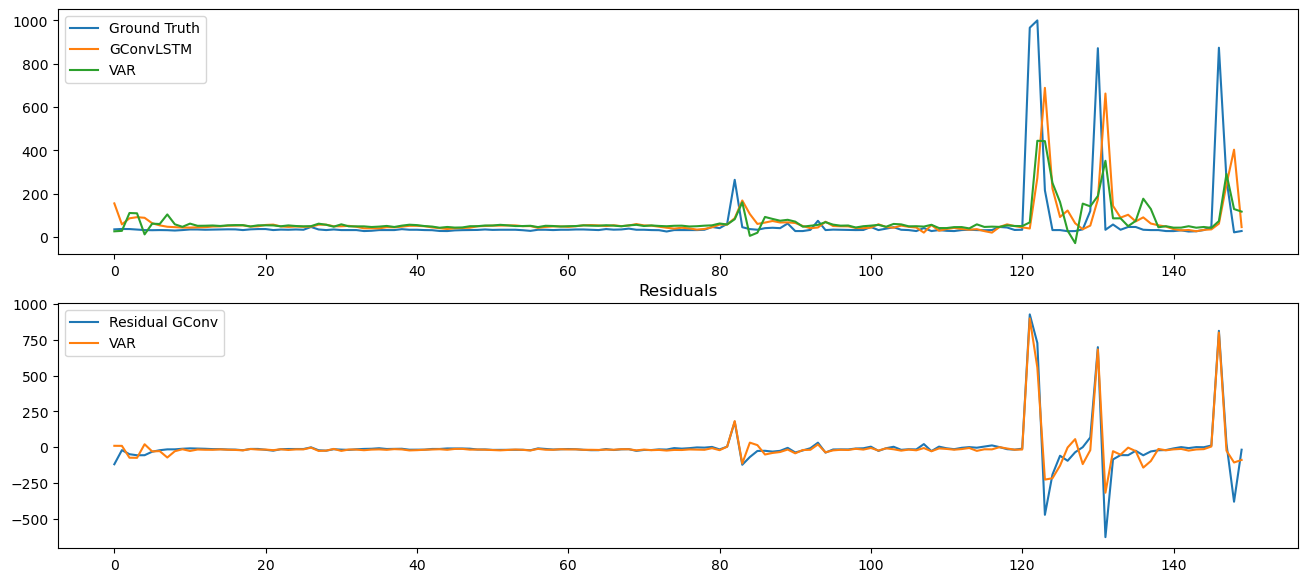

In [43]:
diff1 = [a - b for a, b in zip(targets_hourly_test[hour1], outputs_hourly_test[hour1])]
diff2 = [a - b for a, b in zip(targets_hourly_test[hour2], outputs_hourly_test[hour2])]
fig, axs = plt.subplots(2, 1, figsize=(16, 7))
axs[0].plot(targets_hourly_test[hour2][id:fd], label="Ground Truth")
axs[0].plot(outputs_hourly_test[hour2][id:fd], label=name_model)
axs[0].plot(vec, label='VAR')
axs[0].legend()
#axs[0,1].set_ylim(-40,1040)
axs[1].set_title("Daily series at "+inverse_dict[hour2]+" in first "+str(fd)+" days of the test set")
axs[1].plot(diff2[id:fd], label="Residual GConv")
axs[1].plot([a - b for a, b in zip(targets_hourly_test[hour2][id:fd],vec)], label='VAR')
axs[1].legend()
#axs[1,1].set_ylim(-1040,1040)
axs[1].set_title("Residuals")
plt.show()

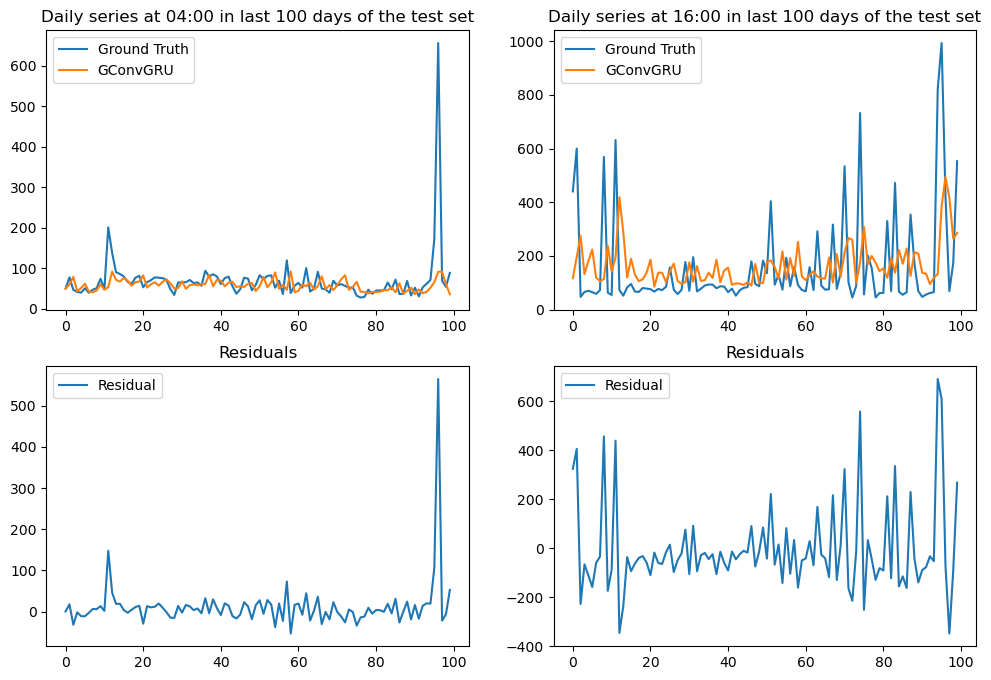

In [27]:
#o uno o l'altro
hour1 = 4
hour2 = 16
fd=100

diff1 = [a - b for a, b in zip(targets_hourly_test[hour1], outputs_hourly_test[hour1])]
diff2 = [a - b for a, b in zip(targets_hourly_test[hour2], outputs_hourly_test[hour2])]
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0,0].plot(targets_hourly_test[hour1][-fd:], label="Ground Truth")
axs[0,0].plot(outputs_hourly_test[hour1][-fd:], label=name_model)
axs[0,0].legend()
#axs[0,0].set_ylim(-40,1040)
axs[0,0].set_title("Daily series at "+inverse_dict[hour1]+" in last "+str(fd)+" days of the test set")
axs[1,0].plot(diff1[-fd:], label="Residual")
axs[1,0].legend()
#axs[1,0].set_ylim(-1040,1040)
axs[1,0].set_title("Residuals")
axs[0,1].plot(targets_hourly_test[hour2][-fd:], label="Ground Truth")
axs[0,1].plot(outputs_hourly_test[hour2][-fd:], label=name_model)
axs[0,1].legend()
#axs[0,1].set_ylim(-40,1040)
axs[0,1].set_title("Daily series at "+inverse_dict[hour2]+" in last "+str(fd)+" days of the test set")
axs[1,1].plot(diff2[-fd:], label="Residual")
axs[1,1].legend()
#axs[1,1].set_ylim(-1040,1040)
axs[1,1].set_title("Residuals")
plt.savefig('../plot/focustestdyn'+name_model.lower()+'.jpg', format='jpg')
plt.show()

In [45]:
df_compare = pd.DataFrame({'a': outputs_hourly_test[hour1][-fd:], 'b': outputs_hourly_test[hour2][-fd:], 'c': diff1[-fd:], 'd': diff2[-fd:]})

In [58]:
# df_compare.to_csv('plot/compare/compare_gconv.csv', index=False)

In [28]:

# Per salvare modello
# model = model.to('cpu')
# torch.save(model.state_dict(), 'models/gnn_dyn'+name_model+'_3_10_5_0.075.pth')


In [11]:
# Per caricare modello
model = RecurrentGCN(node_features = lags)
model.load_state_dict(torch.load('models/gnn_dyn'+name_model+'_3_10_5_0.075.pth'))
#model = model.to('cuda')
print(model)

RecurrentGCN(
  (recurrent): GConvLSTM(
    (conv_x_i): ChebConv(3, 10, K=5, normalization=sym)
    (conv_h_i): ChebConv(10, 10, K=5, normalization=sym)
    (conv_x_f): ChebConv(3, 10, K=5, normalization=sym)
    (conv_h_f): ChebConv(10, 10, K=5, normalization=sym)
    (conv_x_c): ChebConv(3, 10, K=5, normalization=sym)
    (conv_h_c): ChebConv(10, 10, K=5, normalization=sym)
    (conv_x_o): ChebConv(3, 10, K=5, normalization=sym)
    (conv_h_o): ChebConv(10, 10, K=5, normalization=sym)
  )
  (linear): Linear(in_features=10, out_features=1, bias=True)
)


In [13]:
#Training set
H = torch.zeros(24,out_channels)
outputs = []  #
targets = []  #
for time_step, snapshot in enumerate(train_dataset):
    #snapshot.to('cuda')
    output, H = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, H=H)
    train_output = descale(output.T[0].detach().cpu().numpy(), sigma, mu, scale)
    train_snapshot = descale(snapshot.y.detach().cpu().numpy(), sigma, mu, scale)
    outputs.append(train_output)  #
    targets.append(train_snapshot)   #

In [14]:
outputs_hourly = []
targets_hourly = []
for j in range(24):
    outhourlist = [outputs[i][j] for i in range(len(outputs))]
    tarhourlist = [targets[i][j] for i in range(len(outputs))]
    outputs_hourly.append(outhourlist)
    targets_hourly.append(tarhourlist)